# 0.1.0 Cohort Analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")

In [3]:
import sys
sys.path.append("../") 

import utils.paths as path
from utils.paths2 import direcciones

## 0.1.4 Assign daily acquisition cohort

In [6]:
online = pd.read_csv(path.data_raw_dir("online.csv"), sep=',')
online.drop(['Unnamed: 0'], axis=1, inplace=True)
online['InvoiceDate'] = pd.to_datetime(online['InvoiceDate'], format='%Y-%m-%d %H:%M:%S') #, dayfirst='true', errors = 'coerce'
print(online.info())
online.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70864 entries, 0 to 70863
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    70864 non-null  int64         
 1   StockCode    70864 non-null  object        
 2   Description  70864 non-null  object        
 3   Quantity     70864 non-null  int64         
 4   InvoiceDate  70864 non-null  datetime64[ns]
 5   UnitPrice    70864 non-null  float64       
 6   CustomerID   70864 non-null  int64         
 7   Country      70864 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 4.3+ MB
None


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom
1,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom
2,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom
3,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom
4,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom


In [7]:
# Define a function that will parse the date
def get_day(x): return dt.datetime(x.year, x.month, x.day) 

In [8]:
# Create InvoiceDay column
online['InvoiceDay'] = online['InvoiceDate'].apply(get_day) 

In [9]:
# Group by CustomerID and select the InvoiceDay value
grouping = online.groupby('CustomerID')['InvoiceDay'] 

In [10]:
# Assign a minimum InvoiceDay value to the dataset
online['CohortDay'] = grouping.transform('min')

In [11]:
# View the top 5 rows
print(online.head())

   InvoiceNo StockCode                      Description  Quantity  \
0     572558     22745       POPPY'S PLAYHOUSE BEDROOM          6   
1     577485     23196    VINTAGE LEAF MAGNETIC NOTEPAD         1   
2     560034     23299     FOOD COVER WITH BEADS SET 2          6   
3     578307    72349B  SET/6 PURPLE BUTTERFLY T-LIGHTS         1   
4     554656     21756         BATH BUILDING BLOCK WORD         3   

          InvoiceDate  UnitPrice  CustomerID         Country InvoiceDay  \
0 2011-10-25 08:26:00       2.10       14286  United Kingdom 2011-10-25   
1 2011-11-20 11:56:00       1.45       16360  United Kingdom 2011-11-20   
2 2011-07-14 13:35:00       3.75       13933  United Kingdom 2011-07-14   
3 2011-11-23 15:53:00       2.10       17290  United Kingdom 2011-11-23   
4 2011-05-25 13:36:00       5.95       17663  United Kingdom 2011-05-25   

   CohortDay  
0 2011-04-11  
1 2011-09-12  
2 2011-07-14  
3 2011-11-23  
4 2011-02-25  


## 0.1.5 Calculate time offset in days - part 1

In [12]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

In [13]:
# Get the integers for date parts from the `InvoiceDay` column
invoice_year, invoice_month, invoice_day = get_date_int(online, 'InvoiceDay')

In [14]:
# Get the integers for date parts from the `CohortDay` column
cohort_year, cohort_month, cohort_day = get_date_int(online, 'CohortDay')

## 0.1.6 Calculate time offset in days - part 2

In [15]:
# Calculate difference in years
years_diff = invoice_year - cohort_year

# Calculate difference in months
months_diff = invoice_month - cohort_month

# Calculate difference in days
days_diff = invoice_day - cohort_day

In [16]:
# Extract the difference in days from all previous values
online['CohortIndex'] = years_diff * 365 + months_diff * 30 + days_diff + 1
print(online.head())

   InvoiceNo StockCode                      Description  Quantity  \
0     572558     22745       POPPY'S PLAYHOUSE BEDROOM          6   
1     577485     23196    VINTAGE LEAF MAGNETIC NOTEPAD         1   
2     560034     23299     FOOD COVER WITH BEADS SET 2          6   
3     578307    72349B  SET/6 PURPLE BUTTERFLY T-LIGHTS         1   
4     554656     21756         BATH BUILDING BLOCK WORD         3   

          InvoiceDate  UnitPrice  CustomerID         Country InvoiceDay  \
0 2011-10-25 08:26:00       2.10       14286  United Kingdom 2011-10-25   
1 2011-11-20 11:56:00       1.45       16360  United Kingdom 2011-11-20   
2 2011-07-14 13:35:00       3.75       13933  United Kingdom 2011-07-14   
3 2011-11-23 15:53:00       2.10       17290  United Kingdom 2011-11-23   
4 2011-05-25 13:36:00       5.95       17663  United Kingdom 2011-05-25   

   CohortDay  CohortIndex  
0 2011-04-11          195  
1 2011-09-12           69  
2 2011-07-14            1  
3 2011-11-23          

## 0.1.8 Customer retention
Customer retention is a very useful metric to understand how many of all the customers are still active. Which of the following best describes customer retention?

R:/ Percentage of active customers out of total customers. Retention gives you the percentage of active customers compared to the total number of customers.

## 0.1.9 Calculate retention rate from scratch

In [17]:
online = pd.read_csv(path.data_raw_dir("online.csv"), sep=',')
online.drop(['Unnamed: 0'], axis=1, inplace=True)
online['InvoiceDate'] = pd.to_datetime(online['InvoiceDate'], format='%Y-%m-%d %H:%M:%S') #, dayfirst='true', errors = 'coerce'
print(online.info())
online.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70864 entries, 0 to 70863
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    70864 non-null  int64         
 1   StockCode    70864 non-null  object        
 2   Description  70864 non-null  object        
 3   Quantity     70864 non-null  int64         
 4   InvoiceDate  70864 non-null  datetime64[ns]
 5   UnitPrice    70864 non-null  float64       
 6   CustomerID   70864 non-null  int64         
 7   Country      70864 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 4.3+ MB
None


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom
1,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom
2,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom
3,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom
4,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom


In [18]:
def get_month(x): return dt.datetime(x.year, x.month, 1)

In [19]:
online['InvoiceMonth'] = online['InvoiceDate'].apply(get_month)
grouping = online.groupby('CustomerID')['InvoiceMonth']
online['CohortMonth'] = grouping.transform('min')
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth
0,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom,2011-10-01,2011-04-01
1,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom,2011-11-01,2011-09-01
2,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom,2011-07-01,2011-07-01
3,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom,2011-11-01,2011-11-01
4,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom,2011-05-01,2011-02-01


In [20]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

In [21]:
invoice_year, invoice_month, _ = get_date_int(online, 'InvoiceMonth')
cohort_year, cohort_month, _ = get_date_int(online, 'CohortMonth')
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month
online['CohortIndex'] = years_diff * 12 + months_diff + 1
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom,2011-10-01,2011-04-01,7
1,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom,2011-11-01,2011-09-01,3
2,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom,2011-07-01,2011-07-01,1
3,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom,2011-11-01,2011-11-01,1
4,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom,2011-05-01,2011-02-01,4


In [22]:
grouping = online.groupby(['CohortMonth', 'CohortIndex'])

# Count the number of unique values per customer ID
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique).reset_index()

In [23]:
# Create a pivot 
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

In [24]:
# Select the first column and store it to cohort_sizes
cohort_sizes = cohort_counts.iloc[:,0]

In [25]:
# Divide the cohort count by cohort sizes along the rows
retention = cohort_counts.divide(cohort_sizes, axis=0)
print(retention.head())

CohortIndex   1         2         3         4         5         6         7   \
CohortMonth                                                                    
2010-12-01   1.0  0.343575  0.308659  0.350559  0.342179  0.398045  0.347765   
2011-01-01   1.0  0.207831  0.246988  0.243976  0.331325  0.271084  0.246988   
2011-02-01   1.0  0.183544  0.180380  0.262658  0.268987  0.234177  0.253165   
2011-03-01   1.0  0.162371  0.257732  0.195876  0.213918  0.172680  0.252577   
2011-04-01   1.0  0.192157  0.203922  0.192157  0.184314  0.203922  0.219608   

CohortIndex        8         9         10        11        12        13  
CohortMonth                                                              
2010-12-01   0.329609  0.335196  0.370112  0.354749  0.486034  0.240223  
2011-01-01   0.259036  0.313253  0.307229  0.373494  0.135542       NaN  
2011-02-01   0.262658  0.272152  0.300633  0.088608       NaN       NaN  
2011-03-01   0.219072  0.275773  0.097938       NaN       NaN       N

## 0.1.10 Calculate average price

In [26]:
# Create a groupby object and pass the monthly cohort and cohort index as a list
grouping = online.groupby(['CohortMonth', 'CohortIndex']) 

In [27]:
# Calculate the average of the unit price column
cohort_data = grouping['UnitPrice'].mean()

In [28]:
# Reset the index of cohort_data
cohort_data = cohort_data.reset_index()

In [29]:
# Create a pivot 
average_price = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='UnitPrice')
print(average_price.round(1))

CohortIndex   1    2    3    4    5    6    7    8    9    10   11   12   13
CohortMonth                                                                 
2010-12-01   3.0  3.0  3.0  2.8  2.7  6.9  2.8  3.0  2.7  2.7  3.0  2.8  2.6
2011-01-01   3.2  3.1  3.0  3.0  3.1  3.0  3.0  2.5  2.7  2.9  2.6  2.0  NaN
2011-02-01   3.1  4.0  3.3  2.9  3.3  2.9  2.8  2.7  2.9  2.7  3.1  NaN  NaN
2011-03-01   3.5  3.6  3.5  2.8  2.7  2.5  2.7  2.9  2.5  2.4  NaN  NaN  NaN
2011-04-01   3.3  4.4  3.4  2.6  2.8  2.8  2.8  2.6  2.6  NaN  NaN  NaN  NaN
2011-05-01   3.1  2.8  2.5  2.7  2.5  2.3  2.7  2.3  NaN  NaN  NaN  NaN  NaN
2011-06-01   2.8  2.4  2.7  3.1  2.5  2.4  2.5  NaN  NaN  NaN  NaN  NaN  NaN
2011-07-01   3.2  3.1  3.4  2.5  2.4  2.3  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2011-08-01   2.9  3.7  5.4  6.9  4.2  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2011-09-01   2.9  3.1  3.0  2.6  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2011-10-01   2.9  2.7  2.5  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN

## 0.1.11 Visualize average quantity metric

In [30]:
# Calculate the average of the unit price column
cohort_data = grouping['Quantity'].mean()

In [31]:
# Reset the index of cohort_data
cohort_data = cohort_data.reset_index()

In [32]:
# Reset the index of cohort_data
cohort_data = cohort_data.reset_index()

In [33]:
# Create a pivot 
average_quantity = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='Quantity')

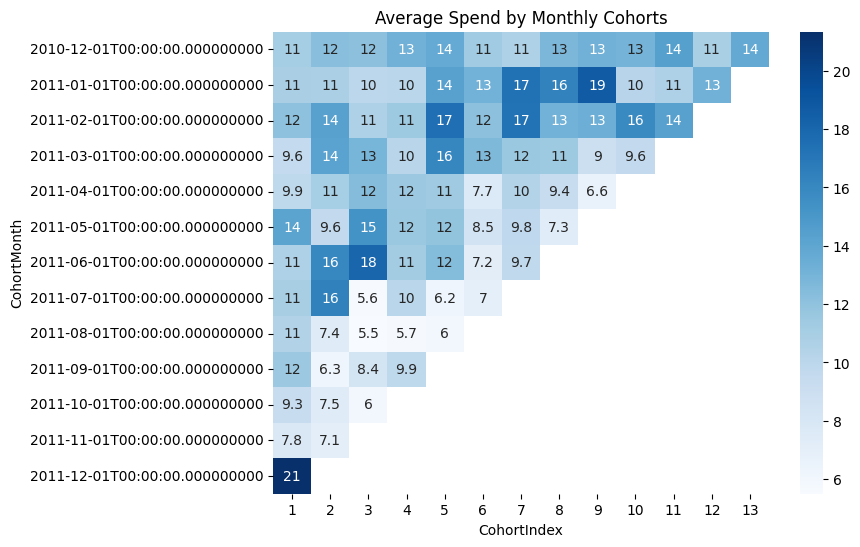

In [34]:
# Initialize an 8 by 6 inches plot figure
plt.figure(figsize=(8, 6))

# Add a title
plt.title('Average Spend by Monthly Cohorts')

# Create the heatmap
sns.heatmap(average_quantity, annot=True, cmap='Blues')
plt.show()

In [35]:
print('ok_')

ok_
